In [2]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 
import matplotlib.patches as patches # Active zones
import matplotlib.path as mplPath

# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook 


## My functions 

In [3]:
# Find Outliers -- upper and lower limit to 3 std 

def find_outliers(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std *3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

## Importing Data from .csv files

In [4]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/ShuffleCsv/Relations/*.csv')

In [5]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [6]:
probeFilteredTrackFiles = []
probeFilteredTrackFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/TrackFiles/TrajectoriesAnalysis/filteredProbeFiles/Track/*.csv")

probeFilteredRelationsFiles = []
probeFilteredRelationsFiles = glob.glob(r"C:/Users/jamesjun/Desktop/Simone/TrackFiles/TrajectoriesAnalysis/filteredProbeFiles/Relations/*.csv")

In [7]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFilteredTrackFiles))) : 
    probeData.append(pd.read_csv(probeFilteredTrackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"], skiprows = 1))
probeShapeData = []
for i in tqdm(range(0,len(probeShapesFiles))) : 
    probeShapeData.append(pd.read_csv(probeShapesFiles[i], names = ["X", "Y", "Angle"]))
    probeShapeData[i] = pd.concat([shape_names,probeShapeData[i]], axis = 1)
    probeShapeData[i] = pd.concat([probeShapeData[i], color_shapes], axis = 1)


probeRelationsData = [] 
for i in tqdm(range(0,len(probeFilteredRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeFilteredRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"],  skiprows = 2))
    


In [8]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

## Plotting example trajectory

In [9]:
df_for_sampling_density_analysis = []

for i in tqdm(range(0,len(trackFiles))) :
    df_for_sampling_density_analysis.append(pd.concat([trackData[i]['Time'],
                                                       trackData[i]['X'], trackData[i]['Y'],trackData[i]['DistanceXEODPulse'], relationsData[i]['TriangleLg'],
                                                        relationsData[i]['TriangleSm'], relationsData[i]['SquareLg'], relationsData[i]['SquareSm'],relationsData[i]['CircleLg'],
                                                       relationsData[i]['CircleSm'], relationsData[i]['Food']], axis=1, keys=['Time', 'X', 'Y', 'DistanceXEODPulse','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm' ,'CircleLg', 'CircleSm', 'Food']))

<IPython.core.display.Javascript object>


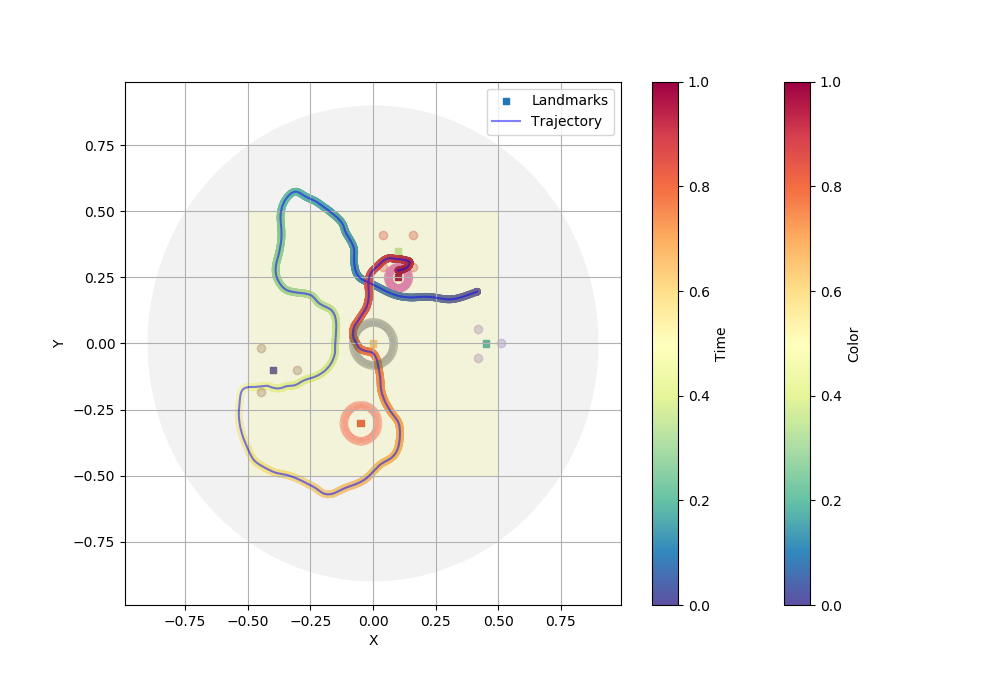

In [37]:
%matplotlib notebook

#Select trajectory number (based on number of videos )
traj_number = 4



# Plotting each trajectory with Spectral colormap based on time --> as James did in matlab 
# The colormap is related to time --> take a look on the side of the plot 

#plt.figure()


fig, ax = plt.subplots()
circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.5,-0.5), 1.0, 1.0, alpha = 0.1, fc = 'yellow')
#circ2 = patches.Circle((0, 0), 0.15, alpha=0.30, fc='red')

ax.add_patch(circ)
ax.add_patch(square)
#ax.add_patch(circ2)


plt.xlim(-1,1)
plt.ylim(-1,1)
# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax, marker = 's', style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r')
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax,c = 'Time', cmap = 'Spectral_r')

# Plotting masks to check 
plt.scatter(vertices_circles(traj_number)[1][:,0],vertices_circles(traj_number)[1][:,1], alpha=0.005)
plt.scatter(vertices_circles(traj_number)[0][:,0],vertices_circles(traj_number)[0][:,1], alpha=0.005)
plt.scatter(vertices_squares(traj_number)[0][:,0],vertices_squares(traj_number)[0][:,1], alpha = 0.3 )
plt.scatter(vertices_squares(traj_number)[1][:,0],vertices_squares(traj_number)[1][:,1], alpha = 0.3 )
plt.scatter(vertices_triangles(traj_number)[0][:,0], vertices_triangles(traj_number)[0][:,1], alpha = 0.3)
plt.scatter(vertices_triangles(traj_number)[1][:,0], vertices_triangles(traj_number)[1][:,1], alpha = 0.3)
plt.scatter(circle_around_food(traj_number)[:,0], circle_around_food(traj_number)[:,1], alpha = 0.003)

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax, style = 'b', alpha = 0.5, grid = True, figsize = (10,6.8), label = 'Trajectory')


plt.Axes.autoscale(ax)

## Creating Landmark Mask 

### Circle Large and Circle Small
Example

In [ ]:
# Creating a mask
radius_small_circle = 0.038 # 7.6 cm (check Jun et al. paper)
radius_large_circle = 0.051 # 10.2 cm (check Jun et al. paper)

# We should decide whether this is a good candidate as a value
radius_small_mask = radius_small_circle + 0.03 # 3cm is related to fish senses (check Jun et al paper)
radius_large_mask =  radius_large_circle + 0.03 



x_pos_vertex = []
y_pos_vertex = [] 
number_of_vertices = 1000 # 1000 Are enough to get a good approximate result 


for m in tqdm(range(0, number_of_vertices)) : 
    x_pos_vertex.append(np.cos(2*m *np.pi/number_of_vertices  ))
    y_pos_vertex.append(np.sin(2*m *np.pi/number_of_vertices  ))

x_pos_vertex = np.asarray(x_pos_vertex)
y_pos_vertex = np.asarray(y_pos_vertex)

x0_small_circle = shapeData[0].iloc[5,1]
y0_small_circle = shapeData[0].iloc[5,2]
x0_large_circle = shapeData[0].iloc[4,1]
y0_large_circle = shapeData[0].iloc[4,2]

x_pos_vertex_small_circle_mask = radius_small_mask*x_pos_vertex + x0_small_circle
y_pos_vertex_small_circle_mask = radius_small_mask*y_pos_vertex + y0_small_circle
x_pos_vertex_large_circle_mask = radius_large_mask*x_pos_vertex + x0_large_circle
y_pos_vertex_large_circle_mask = radius_large_mask*y_pos_vertex + y0_large_circle


vertex_coordinates_large_circle_mask = np.vstack((x_pos_vertex_large_circle_mask, y_pos_vertex_large_circle_mask)).T
vertex_coordinates_small_circle_mask = np.vstack((x_pos_vertex_small_circle_mask, y_pos_vertex_small_circle_mask)).T

#Defining a circle approximation as a polygon in order to get 
polygon_small_circle_approx = vertex_coordinates_small_circle_mask   # poly
polygon_large_circle_approx = vertex_coordinates_large_circle_mask

circlePath_small = mplPath.Path(polygon_small_circle_approx)
circlePath_large = mplPath.Path(polygon_large_circle_approx)

Getting a function out of it 

In [10]:
def vertices_circles(index_shapeData):
    """Returns vertices coordinates for Circle Small and Circle Large masks """
    
    radius_small_circle = 0.038 # 7.6 cm (check Jun et al. paper)
    radius_large_circle = 0.051 # 10.2 cm (check Jun et al. paper)

    # We should decide whether this is a good candidate as a value
    radius_small_mask = radius_small_circle + 0.03 # 3cm is related to fish senses (check Jun et al paper)
    radius_large_mask =  radius_large_circle + 0.03 



    x_pos_vertex = []
    y_pos_vertex = [] 
    number_of_vertices = 1000 # 1000 Are enough to get a good approximate result 


    for m in range(0, number_of_vertices): 
        x_pos_vertex.append(np.cos(2*m *np.pi/number_of_vertices  ))
        y_pos_vertex.append(np.sin(2*m *np.pi/number_of_vertices  ))

    x_pos_vertex = np.asarray(x_pos_vertex)
    y_pos_vertex = np.asarray(y_pos_vertex)

    x0_small_circle = shapeData[index_shapeData].iloc[5,1]
    y0_small_circle = shapeData[index_shapeData].iloc[5,2]
    x0_large_circle = shapeData[index_shapeData].iloc[4,1]
    y0_large_circle = shapeData[index_shapeData].iloc[4,2]

    x_pos_vertex_small_circle_mask = radius_small_mask*x_pos_vertex + x0_small_circle
    y_pos_vertex_small_circle_mask = radius_small_mask*y_pos_vertex + y0_small_circle
    x_pos_vertex_large_circle_mask = radius_large_mask*x_pos_vertex + x0_large_circle
    y_pos_vertex_large_circle_mask = radius_large_mask*y_pos_vertex + y0_large_circle


    vertex_coordinates_large_circle_mask = np.vstack((x_pos_vertex_large_circle_mask, y_pos_vertex_large_circle_mask)).T
    vertex_coordinates_small_circle_mask = np.vstack((x_pos_vertex_small_circle_mask, y_pos_vertex_small_circle_mask)).T
    
    return vertex_coordinates_small_circle_mask, vertex_coordinates_large_circle_mask

### Square Large and Square Small
Example

In [ ]:
# Creating a mask
side_small_square = 0.056 # 5.6 cm (check Jun et al. paper)
side_large_square = 0.09 # 9.0 cm (check Jun et al. paper)

# We should decide whether this is a good candidate as a value
side_small_mask = side_small_square + 0.03 # 3cm is related to fish senses (check Jun et al paper)
side_large_mask = side_large_square + 0.03 



x_pos_vertex_square = []
y_pos_vertex_square = [] 
number_of_vertices_square = 4 

# Adding pi/4 rotation because our squares vertices don't start from angle = 0 
for m in range(0, number_of_vertices_square) : 
    x_pos_vertex_square.append(np.cos(2*m *np.pi/number_of_vertices_square  +np.pi/4))
    y_pos_vertex_square.append(np.sin(2*m *np.pi/number_of_vertices_square  +np.pi/4))

x_pos_vertex_square = np.asarray(x_pos_vertex_square)
y_pos_vertex_square = np.asarray(y_pos_vertex_square)

x0_small_square = shapeData[0].iloc[3,1]
y0_small_square = shapeData[0].iloc[3,2]
x0_large_square = shapeData[0].iloc[2,1]
y0_large_square = shapeData[0].iloc[2,2]

diagonal_small_square_mask = np.sqrt(2)*side_small_mask  
diagonal_large_square_mask = np.sqrt(2)*side_large_mask

x_pos_vertex_small_square_mask = (diagonal_small_square_mask/2)*x_pos_vertex_square + x0_small_square
y_pos_vertex_small_square_mask = (diagonal_small_square_mask/2)*y_pos_vertex_square + y0_small_square
x_pos_vertex_large_square_mask = (diagonal_large_square_mask/2)*x_pos_vertex_square + x0_large_square
y_pos_vertex_large_square_mask = (diagonal_large_square_mask/2)*y_pos_vertex_square + y0_large_square


vertex_coordinates_small_square_mask = np.vstack((x_pos_vertex_small_square_mask, y_pos_vertex_small_square_mask)).T
vertex_coordinates_large_square_mask = np.vstack((x_pos_vertex_large_square_mask, y_pos_vertex_large_square_mask)).T


#Defining a circle approximation as a polygon in order to get 
squarePath_small = mplPath.Path(vertex_coordinates_small_square_mask)
squarePath_large = mplPath.Path(vertex_coordinates_large_square_mask)

Getting a function out of it 

In [11]:
def vertices_squares(index_shapeData):
    """Returns vertices coordinates for Square Small and Square Large masks """
    side_small_square = 0.056 # 5.6 cm (check Jun et al. paper)
    side_large_square = 0.09 # 9.0 cm (check Jun et al. paper)

    # We should decide whether this is a good candidate as a value
    side_small_mask = side_small_square + 0.03 # 3cm is related to fish senses (check Jun et al paper)
    side_large_mask = side_large_square + 0.03 



    x_pos_vertex_square = []
    y_pos_vertex_square = [] 
    number_of_vertices_square = 4 

    # Adding pi/4 rotation because our squares vertices don't start from angle = 0 
    for m in range(0, number_of_vertices_square) : 
        x_pos_vertex_square.append(np.cos(2*m *np.pi/number_of_vertices_square  +np.pi/4))
        y_pos_vertex_square.append(np.sin(2*m *np.pi/number_of_vertices_square  +np.pi/4))

    x_pos_vertex_square = np.asarray(x_pos_vertex_square)
    y_pos_vertex_square = np.asarray(y_pos_vertex_square)

    x0_small_square = shapeData[index_shapeData].iloc[3,1]
    y0_small_square = shapeData[index_shapeData].iloc[3,2]
    x0_large_square = shapeData[index_shapeData].iloc[2,1]
    y0_large_square = shapeData[index_shapeData].iloc[2,2]

    diagonal_small_square_mask = np.sqrt(2)*side_small_mask  
    diagonal_large_square_mask = np.sqrt(2)*side_large_mask

    x_pos_vertex_small_square_mask = (diagonal_small_square_mask/2)*x_pos_vertex_square + x0_small_square
    y_pos_vertex_small_square_mask = (diagonal_small_square_mask/2)*y_pos_vertex_square + y0_small_square
    x_pos_vertex_large_square_mask = (diagonal_large_square_mask/2)*x_pos_vertex_square + x0_large_square
    y_pos_vertex_large_square_mask = (diagonal_large_square_mask/2)*y_pos_vertex_square + y0_large_square


    vertex_coordinates_small_square_mask = np.vstack((x_pos_vertex_small_square_mask, y_pos_vertex_small_square_mask)).T
    vertex_coordinates_large_square_mask = np.vstack((x_pos_vertex_large_square_mask, y_pos_vertex_large_square_mask)).T
    
    return vertex_coordinates_small_square_mask, vertex_coordinates_large_square_mask

### Triangle Large and Triangle Small
Example

In [62]:
# Creating a mask
side_small_triangle = 0.072 # 7.2 cm (check Jun et al. paper)
side_large_triangle = 0.132 # 13.2 cm (check Jun et al. paper)

# We should decide whether this is a good candidate as a value
side_small_mask_triangle = side_small_triangle + (2/np.sqrt(3))*0.03 # 3cm is related to fish senses (check Jun et al paper)
side_large_mask_triangle = side_large_triangle + (2/np.sqrt(3))*0.03 



x_pos_vertex_triangle_small = []
y_pos_vertex_triangle_small = []

x_pos_vertex_triangle_large = []
y_pos_vertex_triangle_large = []

number_of_vertices_triangle = 3 

# Adding pi/4 rotation because our triangles vertices don't start from angle = 0 
for m in range(0, number_of_vertices_triangle) : 
    x_pos_vertex_triangle_small.append(np.cos(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[0].iloc[1,3])))
    y_pos_vertex_triangle_small.append(np.sin(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[0].iloc[1,3])))
    
    x_pos_vertex_triangle_large.append(np.cos(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[0].iloc[0,3])))
    y_pos_vertex_triangle_large.append(np.sin(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[0].iloc[0,3])))

x_pos_vertex_triangle_small = np.asarray(x_pos_vertex_triangle_small)
y_pos_vertex_triangle_small = np.asarray(y_pos_vertex_triangle_small)

x_pos_vertex_triangle_large = np.asarray(x_pos_vertex_triangle_large)
y_pos_vertex_triangle_large = np.asarray(y_pos_vertex_triangle_large)


x0_small_triangle = shapeData[0].iloc[1,1]
y0_small_triangle = shapeData[0].iloc[1,2]
x0_large_triangle = shapeData[0].iloc[0,1]
y0_large_triangle = shapeData[0].iloc[0,2]

radius_from_small_triangle_side = side_small_mask_triangle/np.sqrt(3)
radius_from_large_triangle_side = side_large_mask_triangle/np.sqrt(3)

x_pos_vertex_small_triangle_mask = radius_from_small_triangle_side*x_pos_vertex_triangle_small + x0_small_triangle
y_pos_vertex_small_triangle_mask = radius_from_small_triangle_side*y_pos_vertex_triangle_small + y0_small_triangle
x_pos_vertex_large_triangle_mask = radius_from_large_triangle_side*x_pos_vertex_triangle_large + x0_large_triangle
y_pos_vertex_large_triangle_mask = radius_from_large_triangle_side*y_pos_vertex_triangle_large + y0_large_triangle


vertex_coordinates_small_triangle_mask = np.vstack((x_pos_vertex_small_triangle_mask, y_pos_vertex_small_triangle_mask)).T
vertex_coordinates_large_triangle_mask = np.vstack((x_pos_vertex_large_triangle_mask, y_pos_vertex_large_triangle_mask)).T


#Defining a circle approximation as a polygon in order to get 
trianglePath_small = mplPath.Path(vertex_coordinates_small_triangle_mask)
trianglePath_large = mplPath.Path(vertex_coordinates_large_triangle_mask)

Making a function out of it 

In [12]:
def vertices_triangles(index_shapeData):
    """Returns vertices coordinates of Triangle Small and Triangle Large masks"""
    
    side_small_triangle = 0.072 # 7.2 cm (check Jun et al. paper)
    side_large_triangle = 0.132 # 13.2 cm (check Jun et al. paper)

    # We should decide whether this is a good candidate as a value
    side_small_mask_triangle = side_small_triangle + (2/np.sqrt(3))*0.03 # 3cm is related to fish senses (check Jun et al paper)
    side_large_mask_triangle = side_large_triangle + (2/np.sqrt(3))*0.03 



    x_pos_vertex_triangle_small = []
    y_pos_vertex_triangle_small = []

    x_pos_vertex_triangle_large = []
    y_pos_vertex_triangle_large = []

    number_of_vertices_triangle = 3 

    # Adding pi/4 rotation because our triangles vertices don't start from angle = 0 
    for m in range(0, number_of_vertices_triangle) : 
        x_pos_vertex_triangle_small.append(np.cos(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[index_shapeData].iloc[1,3])))
        y_pos_vertex_triangle_small.append(np.sin(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[index_shapeData].iloc[1,3])))
    
        x_pos_vertex_triangle_large.append(np.cos(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[index_shapeData].iloc[0,3])))
        y_pos_vertex_triangle_large.append(np.sin(2*m *np.pi/number_of_vertices_triangle  - np.radians(shapeData[index_shapeData].iloc[0,3])))

    x_pos_vertex_triangle_small = np.asarray(x_pos_vertex_triangle_small)
    y_pos_vertex_triangle_small = np.asarray(y_pos_vertex_triangle_small)

    x_pos_vertex_triangle_large = np.asarray(x_pos_vertex_triangle_large)
    y_pos_vertex_triangle_large = np.asarray(y_pos_vertex_triangle_large)


    x0_small_triangle = shapeData[index_shapeData].iloc[1,1]
    y0_small_triangle = shapeData[index_shapeData].iloc[1,2]
    x0_large_triangle = shapeData[index_shapeData].iloc[0,1]
    y0_large_triangle = shapeData[index_shapeData].iloc[0,2]

    radius_from_small_triangle_side = side_small_mask_triangle/np.sqrt(3)
    radius_from_large_triangle_side = side_large_mask_triangle/np.sqrt(3)

    x_pos_vertex_small_triangle_mask = radius_from_small_triangle_side*x_pos_vertex_triangle_small + x0_small_triangle
    y_pos_vertex_small_triangle_mask = radius_from_small_triangle_side*y_pos_vertex_triangle_small + y0_small_triangle
    x_pos_vertex_large_triangle_mask = radius_from_large_triangle_side*x_pos_vertex_triangle_large + x0_large_triangle
    y_pos_vertex_large_triangle_mask = radius_from_large_triangle_side*y_pos_vertex_triangle_large + y0_large_triangle


    vertex_coordinates_small_triangle_mask = np.vstack((x_pos_vertex_small_triangle_mask, y_pos_vertex_small_triangle_mask)).T
    vertex_coordinates_large_triangle_mask = np.vstack((x_pos_vertex_large_triangle_mask, y_pos_vertex_large_triangle_mask)).T
    
    return vertex_coordinates_small_triangle_mask, vertex_coordinates_large_triangle_mask

### Food

In [13]:
def circle_around_food(index_shapeData):
    """Returns food mask coordinates"""
    radius_food = 0.0
     
    radius_food_mask = radius_food + 0.04 # 4 cm check on Jun et Al. paper

    x_pos_vertex = []
    y_pos_vertex = [] 
    number_of_vertices = 1000 # 1000 Are enough to get a good approximate result 


    for m in range(0, number_of_vertices) : 
        x_pos_vertex.append(np.cos(2*m *np.pi/number_of_vertices  ))
        y_pos_vertex.append(np.sin(2*m *np.pi/number_of_vertices  ))

    x_pos_vertex = np.asarray(x_pos_vertex)
    y_pos_vertex = np.asarray(y_pos_vertex)

    x0_food = shapeData[index_shapeData].iloc[6,1]
    y0_food = shapeData[index_shapeData].iloc[6,2]

    x_pos_vertex_food_mask = radius_food_mask*x_pos_vertex + x0_food
    y_pos_vertex_food_mask = radius_food_mask*y_pos_vertex + y0_food

    vertex_coordinates_food_mask = np.vstack((x_pos_vertex_food_mask, y_pos_vertex_food_mask)).T
    
    return vertex_coordinates_food_mask


## Extracting Masks for Each landmarks and trial

### Probe Filtered 



In [14]:
accuracy_borders = 0.001 # accuracy

circle_small_zone_list = []
circle_large_zone_list = []
square_small_zone_list = []
square_large_zone_list = []
triangle_small_zone_list = []
triangle_large_zone_list = []
food_zone_list = []

for i in tqdm(range(0, len(probeShapeData))):
    
    # defining Polygons in order to check whether a point is in or out 
    circlePath_small = mplPath.Path(vertices_circles(i)[0])
    circlePath_large = mplPath.Path(vertices_circles(i)[1])
    squarePath_small = mplPath.Path(vertices_squares(i)[0])
    squarePath_large = mplPath.Path(vertices_squares(i)[1])
    trianglePath_small = mplPath.Path(vertices_triangles(i)[0])
    trianglePath_large = mplPath.Path(vertices_triangles(i)[1])
    foodPath = mplPath.Path(circle_around_food(i))
    
    # Getting points by extracting x, y from data 
    pnts = probeData[i].iloc[:,1:3].values # points on edges
    
    # Small Circle 
    isIn_circle_small = [circlePath_small.contains_point(pnt,radius=accuracy_borders) or circlePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_circle_small = np.asarray(isIn_circle_small)
    df_circle_small = pd.DataFrame(data = ArrayIsIn_circle_small)
    df_circle_small.columns = ['ActiveZoneCircleSmall']
    circle_small_zone_list.append(df_circle_small)
    
    # Large Circle 
    isIn_circle_large = [circlePath_large.contains_point(pnt,radius=accuracy_borders) or circlePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_circle_large = np.asarray(isIn_circle_large)
    df_circle_large = pd.DataFrame(data = ArrayIsIn_circle_large)
    df_circle_large.columns = ['ActiveZoneCircleLarge']
    circle_large_zone_list.append(df_circle_large)
    
    #Small Square
    isIn_square_small = [squarePath_small.contains_point(pnt,radius=accuracy_borders) or squarePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_square_small = np.asarray(isIn_square_small)
    df_square_small = pd.DataFrame(data = ArrayIsIn_square_small)
    df_square_small.columns = ['ActiveZoneSquareSmall']
    square_small_zone_list.append(df_square_small)
    
    #Large Square 
    isIn_square_large = [squarePath_large.contains_point(pnt,radius=accuracy_borders) or squarePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_square_large = np.asarray(isIn_square_large)
    df_square_large = pd.DataFrame(data = ArrayIsIn_square_large)
    df_square_large.columns = ['ActiveZoneSquareLarge']
    square_large_zone_list.append(df_square_large)
    
    #Small Triangle 
    isIn_triangle_small = [trianglePath_small.contains_point(pnt,radius=accuracy_borders) or trianglePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_triangle_small = np.asarray(isIn_triangle_small)
    df_triangle_small = pd.DataFrame(data = ArrayIsIn_triangle_small)
    df_triangle_small.columns = ['ActiveZoneTriangleSmall']
    triangle_small_zone_list.append(df_triangle_small)
            
    # Large Triangle 
    isIn_triangle_large = [trianglePath_large.contains_point(pnt,radius=accuracy_borders) or trianglePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_triangle_large = np.asarray(isIn_triangle_large)
    df_triangle_large = pd.DataFrame(data = ArrayIsIn_triangle_large)
    df_triangle_large.columns = ['ActiveZoneTriangleLarge']
    triangle_large_zone_list.append(df_triangle_large)
    
    #Food 
    isIn_food = [foodPath.contains_point(pnt,radius=accuracy_borders) or foodPath.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_food = np.asarray(isIn_food)
    df_food = pd.DataFrame(data = ArrayIsIn_food)
    df_food.columns = ['ActiveZoneFood']
    food_zone_list.append(df_food)

### Create new Relations.csv Files Probe


In [62]:
relations_new_data_probe = []
for i in tqdm(range(0, len(probeRelationsData))):
    relations_new_data_probe.append(probeRelationsData[i].drop(columns = ["TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))
    relations_new_data_probe[i]['ActiveZoneCircleSmall']   = circle_small_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneCircleLarge']   = circle_large_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneSquareSmall']   = square_small_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneSquareLarge']   = square_large_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneTriangleSmall']   = triangle_small_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneTriangleLarge']   = triangle_large_zone_list[i]
    relations_new_data_probe[i]['ActiveZoneFood']   = food_zone_list[i]

### Export relations.csv Files

In [64]:
for i in tqdm(range(0, len(relations_new_data_probe))):
    pd.DataFrame.to_csv(relations_new_data_probe[i], r'C:\Users\jamesjun\Desktop\Simone\TrackFiles\TrajectoriesAnalysis\filteredProbeFiles\Relations/' + probeRelationsFiles[i][58:])

### Early + Late 

In [32]:
accuracy_borders = 0.001 # accuracy

circle_small_zone_list = []
circle_large_zone_list = []
square_small_zone_list = []
square_large_zone_list = []
triangle_small_zone_list = []
triangle_large_zone_list = []
food_zone_list = []

for i in tqdm(range(0, len(shapeData))):
    
    # defining Polygons in order to check whether a point is in or out 
    circlePath_small = mplPath.Path(vertices_circles(i)[0])
    circlePath_large = mplPath.Path(vertices_circles(i)[1])
    squarePath_small = mplPath.Path(vertices_squares(i)[0])
    squarePath_large = mplPath.Path(vertices_squares(i)[1])
    trianglePath_small = mplPath.Path(vertices_triangles(i)[0])
    trianglePath_large = mplPath.Path(vertices_triangles(i)[1])
    foodPath = mplPath.Path(circle_around_food(i))
    
    # Getting points by extracting x, y from data 
    pnts = trackData[i].iloc[:,1:3].values # points on edges
    
    # Small Circle 
    isIn_circle_small = [circlePath_small.contains_point(pnt,radius=accuracy_borders) or circlePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_circle_small = np.asarray(isIn_circle_small)
    df_circle_small = pd.DataFrame(data = ArrayIsIn_circle_small)
    df_circle_small.columns = ['ActiveZoneCircleSmall']
    circle_small_zone_list.append(df_circle_small)
    
    # Large Circle 
    isIn_circle_large = [circlePath_large.contains_point(pnt,radius=accuracy_borders) or circlePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_circle_large = np.asarray(isIn_circle_large)
    df_circle_large = pd.DataFrame(data = ArrayIsIn_circle_large)
    df_circle_large.columns = ['ActiveZoneCircleLarge']
    circle_large_zone_list.append(df_circle_large)
    
    #Small Square
    isIn_square_small = [squarePath_small.contains_point(pnt,radius=accuracy_borders) or squarePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_square_small = np.asarray(isIn_square_small)
    df_square_small = pd.DataFrame(data = ArrayIsIn_square_small)
    df_square_small.columns = ['ActiveZoneSquareSmall']
    square_small_zone_list.append(df_square_small)
    
    #Large Square 
    isIn_square_large = [squarePath_large.contains_point(pnt,radius=accuracy_borders) or squarePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_square_large = np.asarray(isIn_square_large)
    df_square_large = pd.DataFrame(data = ArrayIsIn_square_large)
    df_square_large.columns = ['ActiveZoneSquareLarge']
    square_large_zone_list.append(df_square_large)
    
    #Small Triangle 
    isIn_triangle_small = [trianglePath_small.contains_point(pnt,radius=accuracy_borders) or trianglePath_small.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_triangle_small = np.asarray(isIn_triangle_small)
    df_triangle_small = pd.DataFrame(data = ArrayIsIn_triangle_small)
    df_triangle_small.columns = ['ActiveZoneTriangleSmall']
    triangle_small_zone_list.append(df_triangle_small)
            
    # Large Triangle 
    isIn_triangle_large = [trianglePath_large.contains_point(pnt,radius=accuracy_borders) or trianglePath_large.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_triangle_large = np.asarray(isIn_triangle_large)
    df_triangle_large = pd.DataFrame(data = ArrayIsIn_triangle_large)
    df_triangle_large.columns = ['ActiveZoneTriangleLarge']
    triangle_large_zone_list.append(df_triangle_large)
    
    #Food 
    isIn_food = [foodPath.contains_point(pnt,radius=accuracy_borders) or foodPath.contains_point(pnt,radius=-accuracy_borders) for pnt in pnts]
    ArrayIsIn_food = np.asarray(isIn_food)
    df_food = pd.DataFrame(data = ArrayIsIn_food)
    df_food.columns = ['ActiveZoneFood']
    food_zone_list.append(df_food)

KeyboardInterrupt: 

### Create new Relations.csv Files 

In [153]:
relations_new_data = []
for i in tqdm(range(0, len(relationsData))):
    relations_new_data.append(relationsData[i].drop(columns = ["TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))
    relations_new_data[i]['ActiveZoneCircleSmall']   = circle_small_zone_list[i]
    relations_new_data[i]['ActiveZoneCircleLarge']   = circle_large_zone_list[i]
    relations_new_data[i]['ActiveZoneSquareSmall']   = square_small_zone_list[i]
    relations_new_data[i]['ActiveZoneSquareLarge']   = square_large_zone_list[i]
    relations_new_data[i]['ActiveZoneTriangleSmall']   = triangle_small_zone_list[i]
    relations_new_data[i]['ActiveZoneTriangleLarge']   = triangle_large_zone_list[i]
    relations_new_data[i]['ActiveZoneFood']   = food_zone_list[i]

### Export relations.csv Files

In [166]:
for i in tqdm(range(0, len(relations_new_data))):
    pd.DataFrame.to_csv(relations_new_data[i], r'C:\Users\jamesjun\Desktop\Simone\Csv\ShuffleCsv\NewRelationsFiles/' + relationsFiles[i][58:])